#IMPORTS

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import copy
import os
import re
import tarfile
import zipfile
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from urllib import request
import collections
import gensim
from sklearn.metrics import f1_score, accuracy_score
import gensim.downloader as gloader
import matplotlib.pyplot as plt

In [2]:
EMBEDDING_SIZE = 50

In [3]:
def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use. 
    """
    np.random.seed(seed)
    random.seed(seed)    
    
fix_random(42)

#PRE-PROCESSING

In [4]:
def download_dataset(download_path: str, url: str):  # download dataset
    if not os.path.exists(download_path):
        print("Downloading dataset...")
        request.urlretrieve(url, download_path)
        print("Download complete!")


def extract_dataset(download_path: str, extract_path: str):  # extract dataset
    print("Extracting dataset... (it may take a while...)")
    with zipfile.ZipFile(download_path, 'r') as loaded_zip:
        loaded_zip.extractall(extract_path)
    print("Extraction completed!")


def encode_dataset(dataset_path: str, dataset_folder: str, debug: bool = True) -> (
        pd.DataFrame, int):  # dataset to dataframe
    dataframe_rows = []
    s_lengths = []
    for index, file in tqdm(enumerate(sorted(os.listdir(dataset_path)))):
        file_name = os.path.join(dataset_path, file)
        with open(file_name) as f:
            lines = f.readlines()
        full_file = ''.join(lines)  # since lines is a list we use a single string called full_file

        #LRB RRB COPY FROM ASSIGNMENT 2
        #######  deletes all puntuation #
        #full_file = re.sub(r'[^\w\s]', r'\.', full_file) #replace all puntuaction with period
        ############################################

        full_file = re.sub(r'(\t\d+)', '', full_file)  # remove numbers from each lines of dataset
        full_file = re.sub(r'(\t)', ' ', full_file)  # replace \t with a space
        sentences = full_file.split('\n\n')
        for s in sentences:  # separate all words from their tags
            text = ''.join(re.findall(r'.+ ', s))
            labels = ''.join(re.findall(r' .+', s))
            labels = re.sub(r' (.+)', r'\1 ', labels)
            labels = re.sub('\n', ' ', labels)
            s_lengths.append(len(labels.split(' ')))
            # split into train, val and test
            if index <= 100:
                split = 'train'
            elif 100 < index <= 150:
                split = 'val'
            else:
                split = 'test'

            # create a single row of dataframe
            dataframe_row = {
                "text": text,
                "POStagging": labels,
                "split": split,
            }
            dataframe_rows.append(dataframe_row)

    # transform the list of rows in a proper dataframe
    df = pd.DataFrame(dataframe_rows)
    df = df[["text",
             "POStagging",
             "split"]]
    dataframe_path = os.path.join(dataset_folder, "dependency_treebank_df.pkl")
    df.to_pickle(dataframe_path)
    return df, max(s_lengths)


def create_dataset():
    dataset_folder = os.path.join(os.getcwd(), "Datasets")
    if not os.path.exists(dataset_folder):
        os.makedirs(dataset_folder)

    url = "https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip"

    dataset_path_zip = os.path.join(dataset_folder, "dependency_treebank.zip")
    download_dataset(dataset_path_zip, url)
    extract_dataset(dataset_path_zip, dataset_folder)
    dataset_path = os.path.join(dataset_folder, "dependency_treebank")
    df, max_seq_len = encode_dataset(dataset_path, dataset_folder)
    df['POStagging'] = df['POStagging'].str.lower()
    df['text'] = df['text'].str.lower()
    return df, max_seq_len


def create_trainable(dataset, value_to_key, max_seq_len, num_classes):
    text_ids = [[value_to_key[word] for word in sen.split()] for sen in dataset['text']]
    x_train = []
    y_train = []
    label_tokenizer = {}

    one_hot_idx = 0
    for sen, tagging in zip(text_ids, dataset["POStagging"]):
        tmp = [0] * (max_seq_len - len(sen)) + sen
        x_train.append(tmp)

        for label in tagging.split():
            try:
                check_label = label_tokenizer[label]
            except KeyError:
                label_tokenizer[label] = [1 if i == one_hot_idx else 0 for i in range(num_classes)]
                one_hot_idx += 1

        tmp = [[0] * num_classes] * (max_seq_len - len(sen)) + [label_tokenizer[e] for e in tagging.split()]
        y_train.append(tmp)
    return np.array(x_train), np.array(y_train), label_tokenizer


def get_num_classes(dataset):
    return len(np.unique(''.join(dataset["POStagging"]).split())) + 1  # +1 for the padding

#########################################

try:
    from google.colab import drive
    IN_COLAB=True
except:
    IN_COLAB=False

if IN_COLAB:
    print("We're running Colab")
    # Mount the Google Drive at mount
    mount='/content/gdrive'
    print("Colab: mounting Google drive on ", mount)
    drive.mount(mount)

    # Switch to the directory on the Google Drive that you want to use
    drive_root = mount + "/My Drive/NLP/Assignment1"
    
    # Create drive_root if it doesn't exist
    create_drive_root = True
    if create_drive_root:
        print("\nColab: making sure ", drive_root, " exists.")
        os.makedirs(drive_root, exist_ok=True)
    
    # Change to the directory
    print("\nColab: Changing directory to ", drive_root)
    %cd $drive_root
    print("Checking working directory:")
    %pwd

# download_data('dataset')

We're running Colab
Colab: mounting Google drive on  /content/gdrive
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).

Colab: making sure  /content/gdrive/My Drive/NLP/Assignment1  exists.

Colab: Changing directory to  /content/gdrive/My Drive/NLP/Assignment1
/content/gdrive/My Drive/NLP/Assignment1
Checking working directory:


#CLASSES

##Tokenizer

In [5]:
class Tokenizer(object):
    def __init__(self, dataset_sentences, embedding_dim, glove_dict, glove_matrix):
        self.embedding_matrix = None
        self.value_to_key = {}
        self.value_to_key_new = {}
        self.key_to_value = {}
        self.num_unique_words = 0
        self.dataset_sentences = dataset_sentences
        self.embedding_dim = embedding_dim
        self.glove_dict = glove_dict
        self.glove_matrix = glove_matrix
        self.unique_words = set()

    def get_val_to_key(self):
        return copy.deepcopy(self.value_to_key)

    def tokenize(self):
        self.value_to_key_new = {}
        unique_words = set()
        for sen in self.dataset_sentences:
            for w in sen.split():
                unique_words.add(w)  # get se of unique words
        new_unique = unique_words - self.unique_words
        for i, word in enumerate(new_unique):
            if self.embedding_matrix is not None:
                self.key_to_value[i + len(self.embedding_matrix)] = word  # build two dictionaries for key value correspondence
                self.value_to_key[word] = i + len(self.embedding_matrix)
            else:
                self.key_to_value[i] = word  # build two dictionaries for key value correspondence
                self.value_to_key[word] = i
            self.value_to_key_new[word] = i

        self.num_unique_words = len(new_unique)
        self.unique_words = self.unique_words | new_unique  # union of unique words and new unique words


    def __build_embedding_matrix_glove(self):
        oov_words = []
        tmp_embedding_matrix = np.zeros((self.num_unique_words, self.embedding_dim), dtype=np.float32)
        len_old_emb_matrix = len(self.embedding_matrix) if self.embedding_matrix is not None else 0
        for word, idx in tqdm(self.value_to_key_new.items()):
            try:
                embedding_vector = self.glove_matrix[self.glove_dict[word]]
                tmp_embedding_matrix[idx] = embedding_vector
            except (KeyError, TypeError):
                oov_words.append((word, idx + len_old_emb_matrix))
        if self.embedding_matrix is not None:
            self.embedding_matrix = np.vstack((self.embedding_matrix, tmp_embedding_matrix))
        else:
            self.embedding_matrix = tmp_embedding_matrix
        return oov_words

    def build_embedding_matrix(self):
        oov_words = self.__build_embedding_matrix_glove()
        for word, idx in oov_words:
            neighbour_words = []
            for sen in self.dataset_sentences:  # look for word in sentence
                for i, wanted_word in enumerate(sen):
                    if wanted_word == word:
                        neighbour_words.append(sen[i - 1])  # append previous word in list of neighbours
                        neighbour_words.append(sen[i + 1])  # append next word in list of neighbours
            avg_matrix = np.zeros((len(neighbour_words), self.embedding_dim))  # initialize matrix of avgs

            length_in_vocab = 0  # to check if neighbours are OOV
            for i, el in enumerate(neighbour_words):
                try:
                    avg_matrix[i] = self.embedding_matrix[self.value_to_key[el]]  # check not OOV
                    length_in_vocab += 1  # we don't want to use the zero columns of avg_matrix
                except (KeyError, TypeError):  # the model doesn't exist
                    pass
            if length_in_vocab == 0:
                embedding_vector = np.random.uniform(low=-0.05, high=0.05, size=self.embedding_dim)
            else:
                embedding_vector = np.mean(avg_matrix[:length_in_vocab], axis=0)
            self.embedding_matrix[idx] = embedding_vector
        return copy.deepcopy(self.embedding_matrix)

##Model

In [6]:
class Model(object):
    def __init__(self, model_type, compile_info, value_to_key, embedding_dim, max_seq_len, num_labels,
                 embedding_matrix):

        self.compile_info = compile_info
        self.value_to_key = value_to_key
        self.embedding_dim = embedding_dim
        self.max_seq_len = max_seq_len
        self.num_labels = num_labels
        self.embedding_matrix = embedding_matrix

        if 'baseline' == model_type:
            self.model = self.create_LSTM()
        elif 'gru' == model_type:
            self.model = self.create_GRU()
        elif 'two_lstm' == model_type:
            self.model = self.create_two_LSTM()
        else:
            self.model = self.create_two_Dense()


    def create_LSTM(self) -> keras.Model:

        bidirect_model = keras.models.Sequential()
        bidirect_model.add(layers.Embedding(input_dim=len(self.value_to_key.keys()),
                                            output_dim=self.embedding_dim,
                                            input_length=self.max_seq_len,
                                            mask_zero=True,
                                            weights=[self.embedding_matrix],
                                            trainable=False
                                            ))
        bidirect_model.add(layers.Bidirectional(layers.LSTM(250, return_sequences=True)))
        bidirect_model.add(layers.TimeDistributed(layers.Dense(self.num_labels, activation="softmax")))

        bidirect_model.compile(**self.compile_info)
        bidirect_model.summary()
        return bidirect_model

    def create_GRU(self) -> keras.Model:
        gru = keras.models.Sequential()
        gru.add(layers.Embedding(input_dim=len(self.value_to_key.keys()),
                                 output_dim=self.embedding_dim,
                                 input_length=self.max_seq_len,
                                 mask_zero=True,
                                 weights=[self.embedding_matrix],
                                 trainable=False
                                 ))

        gru.add(layers.GRU(64, return_sequences=True))
        gru.add(layers.TimeDistributed(layers.Dense(self.num_labels, activation="softmax")))
        gru.compile(**self.compile_info)
        gru.summary()
        return gru

    def create_two_LSTM(self) -> keras.Model:
        lstm = keras.models.Sequential()
        lstm.add(layers.Embedding(input_dim=len(self.value_to_key.keys()),
                                  output_dim=self.embedding_dim,
                                  input_length=self.max_seq_len,
                                  mask_zero=True,
                                  weights=[self.embedding_matrix],
                                  trainable=False
                                  ))

        lstm.add(layers.Bidirectional(layers.LSTM(250, return_sequences=True)))
        lstm.add(layers.LSTM(64, return_sequences=True))
        lstm.add(layers.TimeDistributed(layers.Dense(self.num_labels, activation="softmax")))
        lstm.compile(**self.compile_info)
        lstm.summary()
        return lstm

    def create_two_Dense(self) -> keras.Model:
        lstm = keras.models.Sequential()
        lstm.add(layers.Embedding(input_dim=len(self.value_to_key.keys()),
                                  output_dim=self.embedding_dim,
                                  input_length=self.max_seq_len,
                                  mask_zero=True,
                                  weights=[self.embedding_matrix],
                                  trainable=False
                                  ))

        lstm.add(layers.Bidirectional(layers.LSTM(250, return_sequences=True)))
        lstm.add(layers.TimeDistributed(layers.Dense(128, activation="relu")))
        lstm.add(layers.TimeDistributed(layers.Dense(self.num_labels, activation="softmax")))
        lstm.compile(**self.compile_info)
        lstm.summary()
        return lstm

    def show_history(self, history: keras.callbacks.History):

        history_data = history.history
        print("Displaying the following history keys: ", history_data.keys())

        for key, value in history_data.items():
            if not key.startswith('val'):
                fig, ax = plt.subplots(1, 1)
                ax.set_title(key)
                ax.plot(value)
                if 'val_{}'.format(key) in history_data:
                    ax.plot(history_data['val_{}'.format(key)])
                else:
                    print("Couldn't find validation values for metric: ", key)

                ax.set_ylabel(key)
                ax.set_xlabel('epoch')
                ax.legend(['train', 'val'], loc='best')

        plt.show()

    def train_model(self,
                    x_train: np.ndarray,
                    y_train: np.ndarray,
                    x_val: np.ndarray,
                    y_val: np.ndarray,
                    training_info: dict):

        print("Start training! \nParameters: {}".format(training_info))
        history = self.model.fit(x=x_train, y=y_train,
                                 validation_data=(x_val, y_val),
                                 **training_info)
        print("Training completed! Showing history...")

        self.show_history(history)

    def predict_data(self,
                      x: np.ndarray,
                      prediction_info: dict) -> np.ndarray:

        print('Starting prediction: \n{}'.format(prediction_info))
        print('Predicting on {} samples'.format(x.shape[0]))

        predictions = self.model.predict(x, **prediction_info)
        return predictions

#MAIN

In [7]:
df, max_seq_len = create_dataset()

try:
    with open(f"glove-{EMBEDDING_DIMENSION}.pkl", 'rb') as f:
            emb_model = pickle.load(f)
except Exception:
    emb_model = gloader.load(f"glove-wiki-gigaword-{EMBEDDING_DIMENSION}")
    with open(f"glove-{EMBEDDING_DIMENSION}.pkl", 'wb') as f:
        pickle.dump(emb_model, f)

    glove_dict = emb_model.key_to_index
    glove_matrix = emb_model.vectors

tokenizer = Tokenizer(df[df['split'] == 'train']['text'], EMBEDDING_SIZE, glove_dict, glove_matrix)
tokenizer.tokenize()
v2_val_to_key = tokenizer.get_val_to_key()
v2_matrix = tokenizer.build_embedding_matrix()

tokenizer.dataset_sentences = df[df['split'] == 'val']['text']
tokenizer.tokenize()
v3_matrix = tokenizer.build_embedding_matrix()
v3_val_to_key = tokenizer.get_val_to_key()

tokenizer.dataset_sentences = df[df['split'] == 'test']['text']
tokenizer.tokenize()
v4_matrix = tokenizer.build_embedding_matrix()
v4_val_to_key = tokenizer.get_val_to_key()

num_classes = get_num_classes(df[df['split'] == 'train'])
x_train, y_train, tok = create_trainable(df[df['split'] == 'train'], v3_val_to_key, max_seq_len,
                                         num_classes=num_classes)
x_val, y_val, tok = create_trainable(df[df['split'] == 'val'], v3_val_to_key, max_seq_len, num_classes=num_classes)
x_test, y_test, tok = create_trainable(df[df['split'] == 'test'], v4_val_to_key, max_seq_len, num_classes=num_classes)

Extracting dataset... (it may take a while...)
Extraction completed!


199it [00:00, 330.21it/s]
100%|██████████| 1032/1032 [00:00<00:00, 750697.49it/s]


In [13]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df)

                                                   text  \
0     pierre vinken , 61 years old , will join the b...   
1     mr. vinken is chairman of elsevier n.v. , the ...   
2     rudolph agnew , 55 years old and former chairm...   
3     a form of asbestos once used to make kent ciga...   
4     the asbestos fiber , crocidolite , is unusuall...   
5     lorillard inc. , the unit of new york-based lo...   
6     although preliminary findings were reported mo...   
7     a lorillard spokewoman said , `` this is an ol...   
8     we 're talking about years ago before anyone h...   
9        there is no asbestos in our products now . ''    
10    neither lorillard nor the researchers who stud...   
11    `` we have no useful information on whether us...   
12    dr. talcott led a team of researchers from the...   
13    the lorillard spokeswoman said asbestos was us...   
14    from 1953 to 1955 , 9.8 billion kent cigarette...   
15    among 33 men who worked closely with the subst... 

#TRAIN VARIOUS MODELS

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 50)           547350    
                                                                 
 bidirectional (Bidirectiona  (None, 250, 500)         602000    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 250, 46)          23046     
 ibuted)                                                         
                                                                 
Total params: 1,172,396
Trainable params: 625,046
Non-trainable params: 547,350
_________________________________________________________________
Start training! 
Parameters: {'verbose': 1, 'epochs': 1, 'batch_size': 64, 'callbacks': [<keras.callbacks.EarlyStopping object at 0x7f4f114e5050>]}
31/31 [===================

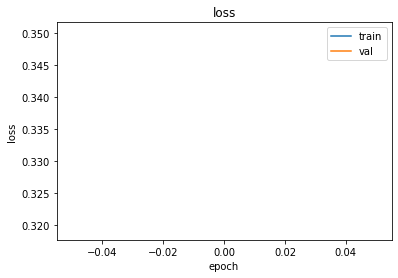

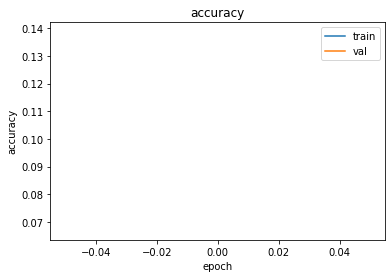

Starting prediction: 
{'batch_size': 64, 'verbose': 1}
Predicting on 644 samples
11/11 [==============================] - 5s 155ms/step
0.008158508158508158


In [8]:
compile_info = {
    'optimizer': keras.optimizers.Adam(learning_rate=1e-3),
    'loss': 'categorical_crossentropy',
    'metrics': ['accuracy']
}

training_info = {
    'verbose': 1,
    'epochs': 1,
    'batch_size': 64,
    'callbacks': [keras.callbacks.EarlyStopping(monitor='val_loss',
                                                patience=10)]
}

model_params = {
    'compile_info': compile_info,
    'value_to_key': v4_val_to_key,
    'embedding_dim': EMBEDDING_SIZE,
    'max_seq_len': max_seq_len,
    'num_labels': num_classes,
    'embedding_matrix': v4_matrix
}

prediction_info = {
    'batch_size': 64,
    'verbose': 1
}

# BASELINE
baseline = Model('baseline', compile_info, v4_val_to_key, EMBEDDING_SIZE, max_seq_len,
                 num_labels=num_classes, embedding_matrix=v4_matrix)
baseline_train = baseline.train_model(x_train=x_train, y_train=y_train,
                             x_val=x_val, y_val=y_val, training_info=training_info)

# GRU
#gru_model = Model('gru', compile_info, v3_val_to_key, EMBEDDING_SIZE, max_seq_len,
                   #          num_labels=num_classes, embedding_matrix=v3_matrix)

#gru_train_model = Model.train_model(x_train=x_train, y_train=y_train,
                      #              x_val=x_val, y_val=y_val, training_info=training_info)

# TWO LSTM
'''twolstm_model = Model('two_lstm', compile_info, v3_val_to_key, EMBEDDING_SIZE, max_seq_len,
                                      num_labels=num_classes, embedding_matrix=v3_matrix)
                                      
twolstm_train_model = Model.train_model(x_train=x_train, y_train=y_train,
        x_val=x_val, y_val=y_val, training_info=training_info)

# TWO DENSE
twodense_model = Model('two_dense', compile_info, v3_val_to_key, EMBEDDING_SIZE, max_seq_len,
                                        num_labels=num_classes, embedding_matrix=v3_matrix)

twodense_train_model = Model.train_model(x_train=x_train, y_train=y_train,
                                    x_val=x_val, y_val=y_val, training_info=training_info)'''


y_pred = baseline.predict_data(x_test, prediction_info=prediction_info)
y_pred = [np.argmax(el) for el in y_pred]  # from one hot to label index
y_true = [np.argmax(el) for el in y_test]
f1_score = f1_score(y_true, y_pred, average='macro')
print(f1_score)